In [1]:
import h5py
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,add
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
save = True # should models be saved? Warning: Will overwrite previously trained models

In [3]:
tf.keras.backend.clear_session()

In [4]:
f = h5py.File('data/phase_diagram_56_rephased.h5', 'r')

In [5]:
phase = f["parameter"]["phase"][:]
freq = f["parameter"]["freq"][:]

In [6]:
uphase = np.unique(phase)
ufreq = np.unique(freq)
X,Y = np.meshgrid(uphase,ufreq)

In [7]:
def train_mask(freq0,freq1,phase0,phase1):
    pick_freq = np.where((freq >= freq0) & (freq <= freq1))
    pick_phase = np.where((phase >= phase0) & (phase <= phase1))
    return np.intersect1d(pick_freq,pick_phase)

In [8]:
print(freq.min(),freq.max(),phase.min(),phase.max())

5.1000000000000005 7.8 -180.0 180.0


In [9]:
images = f["images"][:][:,:,:,np.newaxis]
images.shape

(10436, 56, 56, 1)

In [10]:
# Theory data
file = h5py.File("data/phase_diagram_theory.h5","r")
file.keys()

chern_number = file["chern_number"][:]
freq0 = file["freq"][:]
phase0 = file["phase"][:]

x0,y0 = np.meshgrid(phase0,freq0)

In [11]:
rate=0.15 # Dropout percentage
bottleneck = 50 # latent space dimension, does not make great differences

In [12]:
def ConvFully2(loss,optimizer,activation0,activation,x_shape,dim1=(16,(3,3)),dim2=(16,(3,3))):
    """ 
    Pretty Standard Convolutional Autoencoder with a fully-connected latent space
    activation0: Activations "inside" the CAE
    activation: Last activation (important depending on the range of the pixel values)
    """
    in_dim = x_shape
    input_img = Input(shape=in_dim)
   
    x1 = Conv2D(*dim1, activation=activation0, padding='same')(input_img)
    x2 = MaxPooling2D((2, 2), padding='same')(x1)
    x2 = Conv2D(*dim2, activation=activation0, padding='same')(x2)
    x3 = MaxPooling2D((2, 2), padding='same')(x2)
    encoded = Conv2D(*dim2, activation=activation0, padding='same')(x3)
    
    encoded = Flatten()(encoded)
    encoded = Dense(units=50,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = Dense(dim2[0]*14*14,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = tf.keras.layers.Reshape((14,14,dim2[0]))(encoded)

    y=UpSampling2D((2, 2))(encoded)
    y=Conv2D(*dim1, activation=activation0, padding='same')(y)
    y=UpSampling2D((2, 2))(y)
    decoded = Conv2D(x_shape[-1], dim1[1], activation=activation, padding='same')(y)

    cnn = Model(input_img, decoded)
    cnn.compile(loss=loss,optimizer=optimizer)
    return cnn

In [13]:
# Show Network architecture
cnn = ConvFully2("mse","adam","linear","relu",x_shape=(56,56,1))
cnn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

In [14]:
def norm2(y_true,y_pred):
    """ just the standard l2 norm, needed for evaluation """
    return np.sqrt(np.sum(np.abs(y_true - y_pred)**2))

def eval_loss(x_batch,y_batch,norm=norm2):
    a = []
    for i in range(x_batch.shape[0]):
        a.append(norm(x_batch[i],y_batch[i]))
    return np.array(a)

def training_run(x_train,choose_cnn, name = "", provide_cnn = False,
             load_prev=False, num_epochs = 10,  verbose_val=1, batch_size = 128, shuffle=True, early=False,
             loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
             dim1=(16,(3,3)),dim2=(16,(3,3)),ssc1=False,ssc2=False):
    """
    provide_cnn is to continue the training of a cnn
    load_prev is to load a previously trained network under the same paramters
    x_train provide training data
    """
        
    name_string = name
    CNN_filepath= 'CNN_data/Anomaly-Detection_' + name_string + 'weights.hdf5'

    cnn = choose_cnn(loss,optimizer,activation0,activation,x_train.shape[1:],dim1,dim2) #ssc1, ssc2
    if load_prev:
        cnn.load_weights(CNN_filepath)
    else:
        if provide_cnn:
            cnn = provide_cnn
        # checkpoint
        checkpoint = ModelCheckpoint(CNN_filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='max')
        callbacks_list = [checkpoint]
        if early:
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None)#, restore_best_weights=True)
            callbacks_list.append(early_stop)

        history=cnn.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size,validation_data=(x_train,x_train),callbacks=callbacks_list,verbose=verbose_val,shuffle=shuffle)
        np.savez('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',loss=history.history['loss'],val_loss=history.history['val_loss'])#,acc=history.history['acc'],val_acc=history.history['val_acc'])

    # training history
    plotname = 'plots/Anomaly-Detection_training-history' +  name_string
    hist = np.load('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',allow_pickle="True")
    loss = hist["loss"]
    val_loss = hist["val_loss"]
    plt.plot(loss, linewidth=2, label='Train')
    plt.plot(val_loss, linewidth=2, label='Val')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale("log")
    #plt.ylim(ymin=0.70,ymax=1)
    plt.savefig(plotname + 'training.png', format="png")
    plt.show()
    return cnn

In [15]:
# A full run consisting of training and evaluation
def full_run(x_train,
             dim1=(16,(3,3)),dim2 = (16,(3,3)), activation = "linear", activation0="relu",
             choose_cnn = ConvFully2, provide_cnn = False,
             num_batch_epochs = 1, batch_epochs=30, batch_size = 16, load_prev = False, training = 0,
             pick_phase = 18):
    """
    choose_cnn: provide function that builds respective architecture
    provide_cnn: continue training of a previous NN instance
    batch_epochs: number of epochs per training-batch
    num_batch_epochs: number of training-batches (sorry for confusing terminology of "batch")
    batch_size: tf parameter
    name: provide name for saving network parameters
    load_prev: when the training was already done, reload parameters (all hyper-parameters and parameters must match!)
    pick_phase: for evaluation, which phase is picked to display the single cut
    """
    
    for batch in range(num_batch_epochs):
        if batch == 0:
            provide_cnn = provide_cnn
        else:
            provide_cnn = cnn1
        cnn1 = training_run(x_train = x_train,choose_cnn = choose_cnn, name = "{}".format(training), provide_cnn = provide_cnn,
             load_prev=load_prev, num_epochs = batch_epochs,  verbose_val=1, batch_size = batch_size, shuffle=True, early=False,
             loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam", dim1=dim1,dim2=dim2)
        out,dout,res = create_out(cnn1)
        
        
        phase90 = X[:,pick_phase][0]
        ### Plot
        fig, ax = plt.subplots()
        # plot result
        im = ax.pcolormesh(X,Y,out.T,cmap="jet")
        fig.colorbar(im,ax=ax)
        # theory curve
        ax.contour(x0,y0,np.round(chern_number.T),levels=2)
        ax.set_xlim(uphase.min(),uphase.max())
        ax.set_ylim(ufreq.min(),ufreq.max())
        ax.plot([phase90]*2,[ufreq.min(),ufreq.max()],"--")
        for phases,freqs in zip(train_phases,train_freqs):
            plt.fill_between(*[phases],*freqs,alpha=0.3)
        plt.show()

        fig, ax = plt.subplots()
        plt.errorbar(Y[:,pick_phase],out.T[:,pick_phase],yerr=dout.T[:,pick_phase])
        plt.title(f"phase = {X[:,pick_phase][0]}")
        for phases,freqs in zip(train_phases,train_freqs):
            plt.fill_between(*[freqs],out.T[:,pick_phase].min(),out.T[:,pick_phase].max(),alpha=0.3,color="orange")
        ax.axvline(6.1, color='black') # expected transition
        ax.axvline(6.8, color='black') # expected transition
        plt.show()
    return cnn1, out, dout, res

In [16]:
def create_out(cnn1):
    """
    Creates (dim_freq, dim_phase) matrix of the output loss and the standard deviation
    """
    images_out = cnn1.predict(images)

    res = eval_loss(images,images_out,norm=norm2)/eval_loss(images,0*images,norm=norm2)

    uphase = np.unique(phase)

    ufreq = np.unique(freq)

    X,Y = np.meshgrid(uphase,ufreq)

    out = np.zeros((len(uphase),len(ufreq)))
    dout = np.zeros((len(uphase),len(ufreq)))

    for i,ph in enumerate(uphase):
        for j,fr in enumerate(ufreq):
            mask = np.intersect1d(np.where(freq == fr),np.where(phase == ph))
            out[i,j] = np.mean(res[mask])
            dout[i,j] = np.std(res[mask])
    return out, dout, res

In [17]:
# this is here the results, i.e. the loss values and its error are going to be saved
# res is the full-stack data list while out is averaged and aranged
cnns, outs, douts, res = [None] * 3,[None] * 3, [None] * 3, [None] * 3 

In [18]:
train_freqss = []
train_phasess = []

# 1 Training

## 1.1 Low Freqs

In [19]:
tf.keras.backend.clear_session()

In [20]:
training = 0

In [21]:
train_freqs = [(5,5.5)]
train_phases = [(-180,180)]
train_freqss.append(train_freqs)
train_phasess.append(train_phases)

[(1860, 56, 56, 1)]
(1860, 56, 56, 1)


(-180.0, 180.0)

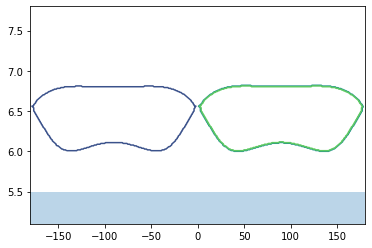

In [22]:
x_train = []
for phases,freqs in zip(train_phases,train_freqs):
    x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
print([_.shape for _ in x_train])
x_train = np.concatenate(x_train)
print(x_train.shape)
fig, ax = plt.subplots()
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
for phases,freqs in zip(train_phases,train_freqs):
    plt.fill_between(*[phases],*freqs,alpha=0.3)
plt.ylim(freq.min(),freq.max())
plt.xlim(phase.min(),phase.max())

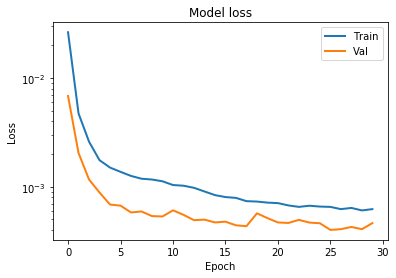

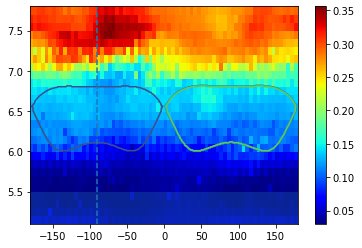

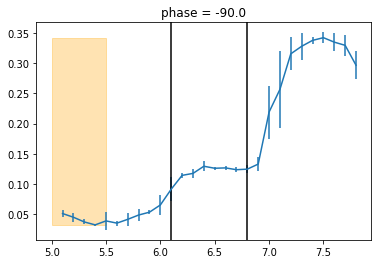

In [23]:
cnns[training], outs[training], douts[training], res[training] = full_run(x_train, load_prev=True, training = training)

In [24]:
if save == True:
    cnns[training].save(f"networks/anomaly_detection/Anomaly-Detection-network-{training}")

## 1.2 High Freqs

In [25]:
training = 1

In [26]:
tf.keras.backend.clear_session()

In [27]:
train_freqs = [(7.25,7.65)]
train_phases = [(-180,180)]
train_freqss.append(train_freqs)
train_phasess.append(train_phases)

[(1492, 56, 56, 1)]
(1492, 56, 56, 1)


(-180.0, 180.0)

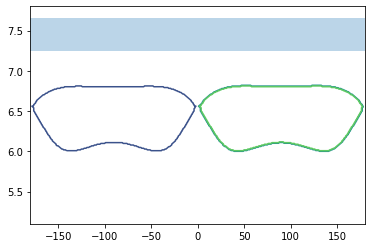

In [28]:
x_train = []
for phases,freqs in zip(train_phases,train_freqs):
    x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
print([_.shape for _ in x_train])
x_train = np.concatenate(x_train)
print(x_train.shape)
fig, ax = plt.subplots()
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
for phases,freqs in zip(train_phases,train_freqs):
    plt.fill_between(*[phases],*freqs,alpha=0.3)
plt.ylim(freq.min(),freq.max())
plt.xlim(phase.min(),phase.max())

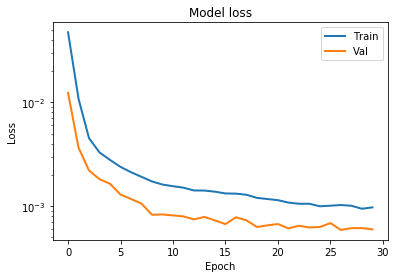

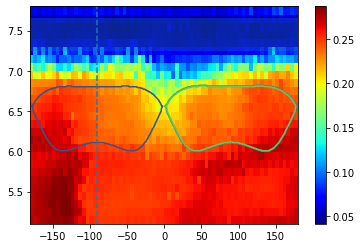

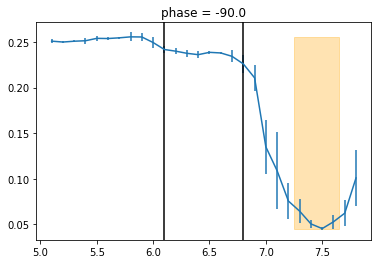

In [29]:
cnns[training], outs[training], douts[training], res[training] = full_run(x_train, load_prev=True, training = training)

In [30]:
if save == True:
    cnns[training].save(f"saved_models/Anomaly-Detection-network-{training}")

## 1.3 Topological

In [31]:
training = 2

In [32]:
tf.keras.backend.clear_session()

In [33]:
train_freqs = [(6.4,6.6)]
train_phases = [(-180,180)]
train_freqss.append(train_freqs)
train_phasess.append(train_phases)

[(1119, 56, 56, 1)]
(1119, 56, 56, 1)


(-180.0, 180.0)

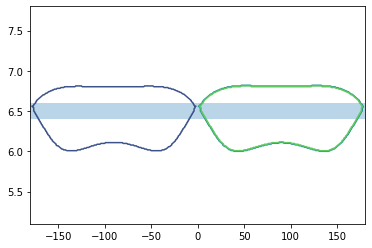

In [34]:
x_train = []
for phases,freqs in zip(train_phases,train_freqs):
    x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
print([_.shape for _ in x_train])
x_train = np.concatenate(x_train)
print(x_train.shape)
fig, ax = plt.subplots()
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
for phases,freqs in zip(train_phases,train_freqs):
    plt.fill_between(*[phases],*freqs,alpha=0.3)
plt.ylim(freq.min(),freq.max())
plt.xlim(phase.min(),phase.max())

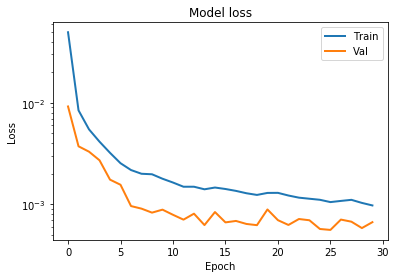

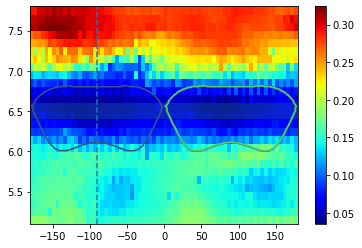

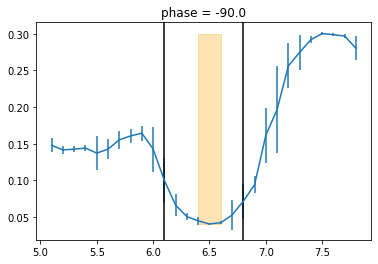

In [35]:
cnns[training], outs[training], douts[training], res[training] = full_run(x_train, load_prev=True, training = training)

In [36]:
if save == True:
    cnns[training].save(f"saved_models/Anomaly-Detection-network-{training}")

# 2 Boundary Estimation

In [37]:
def get_pickle(x, xmin,xmax):
    #x = np.asarray(x)
    pickle = np.where((x>= xmin) & (x <= xmax))
    return pickle, x[pickle]

In [38]:
# tanh for fitting with curve_fit from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return a * np.tanh(b * x - c) + d

In [39]:
def get_xxyy(fr0,fr1,ph,training, p0 = [0.1, 4, 30,0.1], debug=False):
    pickle = np.intersect1d(np.where((freq>= fr0) & (freq <= fr1)),np.where(phase == ph))
    xx,yy = freq[pickle],res[training][pickle]
    sorter = np.argsort(xx)
    xx,yy = xx[sorter],yy[sorter]
    popt, pcov = curve_fit(func, xx, yy, p0 = p0,maxfev = 50000)
    a, b, c, d = popt
    da, db, dc, dd = np.sqrt(np.diag(pcov))
    xc = c/b
    dxc = np.abs(xc * (dc/np.abs(c) - db/np.abs(b)))
    if debug:
        print(f"popt = {popt}, phase {ph:.4f}, db = {db:.4f}, dc = {dc:.4f}, xc = {xc:.4f}, dxc = {dxc:.4f}")
    return xx,yy,func(xx,*popt), xc, dxc

popt = [ 0.04284624  5.85761189 35.52836389  0.08327468], phase -90.0000, db = 0.7307, dc = 4.4283, xc = 6.0653, dxc = 0.0006


<ErrorbarContainer object of 3 artists>

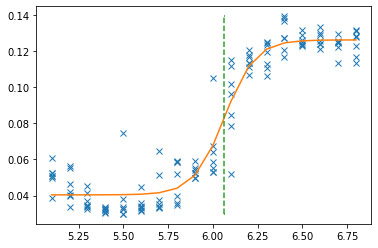

In [40]:
# example (gonna do this in a for-loop)
xx,yy,fxx, xc, dxc = get_xxyy(0,6.8,-90,training=0, debug=True)
plt.plot(xx,yy,"x")
plt.plot(xx,fxx)
plt.errorbar([xc]*2,[yy.min(),yy.max()],xerr=[dxc,dxc],fmt="--")

In [41]:
def get_boundary(phase0,fmin,fmax,training = 0, p0 = [0.1, 4, 30,0.1],plot=True, debug=False):
    # get boundary data for phase0
    xcs0 = np.zeros(len(phase0))
    dxcs0 = np.zeros(len(phase0))
    nrows=len(pickle[0])//3 + 1
    if plot:
        fig, axs = plt.subplots(nrows=nrows, ncols=3,figsize=(15,4*nrows))
    for row,ph in enumerate(phase0):
        xx,yy,fxx, xc, dxc = get_xxyy(fmin,fmax,ph,training,p0,debug)
        xcs0[row], dxcs0[row] = xc, dxc
        if plot:
            ax = axs[row//3,row%3]
            ax.plot(xx,yy,"x")
            ax.plot(xx,fxx)
            ax.plot([xc]*2,[yy.min(),yy.max()],"--")
            ax.set_title(f"phase = {ph}")
    return xcs0, dxcs0

## 2.1 Training 1

In [42]:
training = 0

In [43]:
pickle, phase0 = get_pickle(uphase,-180,180)
xcs0, dxcs0 = get_boundary(phase0,5,6.8, training = training,plot=False)

In [44]:
pickle, phase01 = get_pickle(uphase,-180,180)
xcs01, dxcs01 = get_boundary(phase01,6.3,7.5, training = training,plot=False,debug=False)

/home/kkottmann/.conda/envs/tftwo/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/kkottmann/.conda/envs/tftwo/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [45]:
# cleanup points where fit failed
mask = np.where(np.logical_or(xcs01 > 7.8, xcs01 <6))[0]
xcs01 = np.delete(xcs01,mask)
dxcs01 = np.delete(dxcs01,mask)
phase01 = np.delete(phase01,mask)

# cleanup points where fit failed
mask = np.where(np.logical_or(xcs0 > 6.5, xcs0 <5.5))[0]
xcs0 = np.delete(xcs0,mask)
dxcs0 = np.delete(dxcs0,mask)
phase0 = np.delete(phase0,mask)

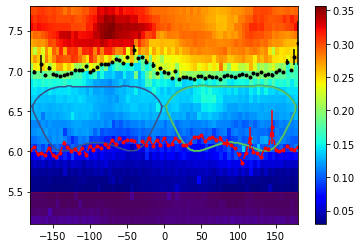

In [46]:
fig, ax = plt.subplots()
# plot result
im = ax.pcolormesh(X,Y,outs[training].T,cmap="jet")
fig.colorbar(im,ax=ax)
# theory curve
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
ax.set_xlim(uphase.min(),uphase.max())
ax.set_ylim(ufreq.min(),ufreq.max())
for phases,freqs in zip(train_phasess[training],train_freqss[training]):
    plt.fill_between(*[phases],*freqs,alpha=0.3,color="red")
plt.errorbar(phase0, xcs0, yerr=dxcs0,fmt=".--",color="red")
plt.errorbar(phase01, xcs01, yerr=dxcs01,fmt=".",color="k")
plt.show()

# Training 2

In [47]:
training = 1

In [48]:
pickle, phase1 = get_pickle(uphase,-180,180)
xcs1, dxcs1 = get_boundary(phase1,6.3,7.8,p0=[0.1, -4, -30,0.1], training = training,plot=False)

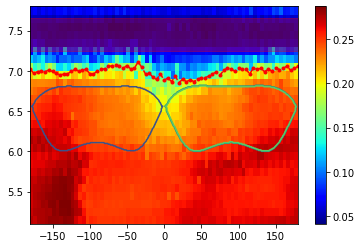

In [49]:
fig, ax = plt.subplots()
# plot result
im = ax.pcolormesh(X,Y,outs[training].T,cmap="jet")
fig.colorbar(im,ax=ax)
# theory curve
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
ax.set_xlim(uphase.min(),uphase.max())
ax.set_ylim(ufreq.min(),ufreq.max())
for phases,freqs in zip(train_phasess[training],train_freqss[training]):
    plt.fill_between(*[phases],*freqs,alpha=0.3,color="red")
plt.errorbar(phase1, xcs1, yerr=dxcs1,fmt=".--",color="red")
plt.show()

# Training 3

In [50]:
training = 2

In [51]:
pickle, phase2 = get_pickle(uphase,-180,180)
xcs2, dxcs2 = get_boundary(phase2,5,6.6, p0 = [0.05, -8, -50,0.1], training = training,plot=False, debug=False)

In [52]:
pickle, phase21 = get_pickle(uphase,-180,180)
xcs21, dxcs21 = get_boundary(phase21,6.3,7.8,p0=[0.1, -4, -30,0.1], training = training,plot=False, debug=False)

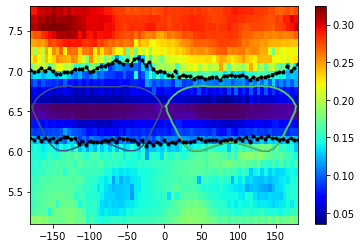

In [53]:
fig, ax = plt.subplots()
# plot result
im = ax.pcolormesh(X,Y,outs[training].T,cmap="jet")
fig.colorbar(im,ax=ax)
# theory curve
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
ax.set_xlim(uphase.min(),uphase.max())
ax.set_ylim(ufreq.min(),ufreq.max())
for phases,freqs in zip(train_phasess[training],train_freqss[training]):
    plt.fill_between(*[phases],*freqs,alpha=0.3,color="red")
plt.errorbar(phase2, xcs2, yerr=dxcs2,fmt=".--", color="k")
plt.errorbar(phase21, xcs21, yerr=dxcs21,fmt=".--", color="k")
plt.show()

In [54]:
boundaries = {
    "0" : [(phase0,xcs0,dxcs0),(phase01,xcs01,dxcs01)],
    "1" : [(phase1,xcs1,dxcs1)],
    "2" : [(phase2,xcs2,dxcs2),(phase21,xcs21,dxcs21)],
}

In [55]:
np.savez("influence/data_and_masks/boundaries",boundaries=boundaries)

In [56]:
bounds = np.load("influence/data_and_masks/boundaries.npz",allow_pickle=True)["boundaries"].item() # .item is needed because numpy saves data in numpy arrays

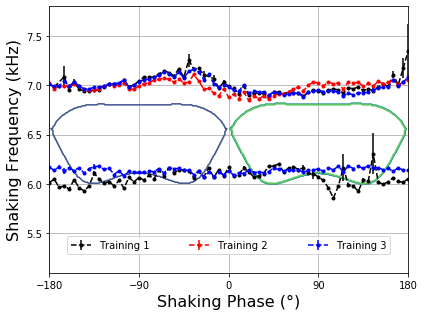

In [57]:
fig, ax = plt.subplots(figsize=(6,4.5))
# plot result
#im = ax.pcolormesh(X,Y,outs[training].T,cmap="jet")
#fig.colorbar(im,ax=ax)
# theory curve
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
ax.set_xlim(uphase.min(),uphase.max())
ax.set_ylim(ufreq.min(),ufreq.max())
colors = ["k","red","blue","magenta","green"]
labels = [f"Training {i+1}" for i in range(5)]
for i in range(3):
    for j,(x,y,dy) in enumerate(bounds[f"{i}"]):
        label = None
        if j == 0:
            label = labels[i]
        ax.errorbar(x,y,yerr=dy,fmt=".--",color=colors[i],label=label)
#for i in [3,4]:
#    for y,x,dx in bounds[f"{i}h"]:
#        ax.errorbar(x,y,xerr=dx,fmt=".--",color=colors[i])
plt.legend(loc='lower left',bbox_to_anchor=(0.05, 0.07, 0.9, .102),
           ncol=3, mode="expand", borderaxespad=0.)
plt.xticks([-180,-90,0,90,180])
plt.ylabel("Shaking Frequency (kHz)",fontsize=16)
plt.xlabel("Shaking Phase (°)",fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig("boundaries_solo.pdf",dpi=300)

# 3 Plot main figure anomaly detection

In [58]:
pick_phases = [18,18,18] # where to do the single cut image

In [59]:
# for consistency with co-authors
face_colors = {
    'orange': [0.8906, 0.4609, 0.4062],
    'gray': [0.6523, 0.6484, 0.6484],
    'blue': [0.5156, 0.5977, 0.8789]
}
edge_colors = {
    'orange': [0.9961, 0, 0],
    'gray': [0.4805, 0.4766, 0.4766],
    'blue': [0, 0, 0.9961]
}

edge_colors_arr = [ec for ec in edge_colors.values()]
face_colors_arr = [fc for fc in face_colors.values()]

cycler = (plt.cycler(mec=edge_colors_arr)+
          plt.cycler(mfc=face_colors_arr)+
          plt.cycler(color=edge_colors_arr))

plt.rcParams.update({
    #'figure.figsize': (12, 8),
    'font.size': 12,
    #'lines.markeredgewidth': 2,
    #'lines.markersize': 9,
    #'lines.marker': 'x',
    #'lines.linestyle': '-',
    #'lines.linewidth': 3,
    'axes.prop_cycle': cycler
    })

In [60]:
fitcolor = "k" #,edge_colors["gray"]

In [61]:
# just cosmetics to make the frame indicating the training region better visible
train_freqss[0], train_phasess[0], train_phasess[1] = np.array([[5.125 , 5.5]]), np.array([[-178 , 178]]), np.array([[-178 , 178]])

In [62]:
# scale to be percent
for i in range(3):
    outs[i] = 100*outs[i]
    douts[i] = 100*douts[i]
    res[i] = 100*res[i]

[-178  178] [5.125 5.5  ]
[-178  178] (7.25, 7.65)
(-180, 180) (6.4, 6.6)


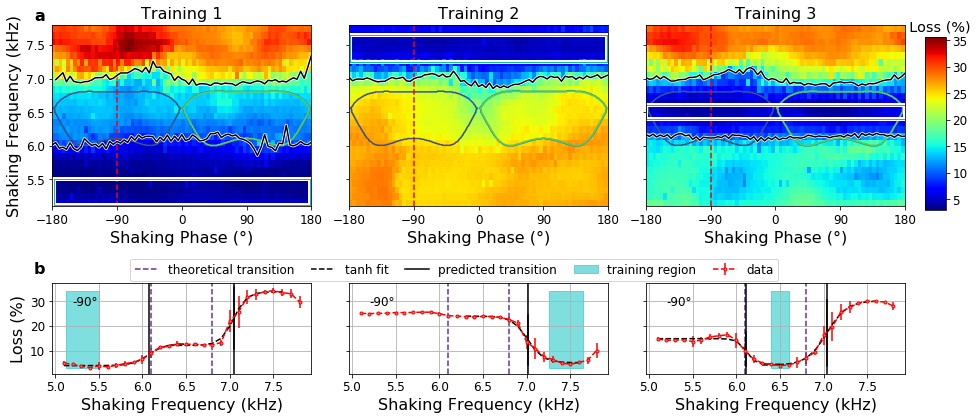

In [65]:
fig, axs = plt.subplots(2, 3, gridspec_kw={'height_ratios': [3, 1.5]},figsize=(14,6),sharey="row")
fillalpha, fillcolor = 0.5, "c"
cmap = "jet" # good diverging cmap: "seismic" https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
vmin, vmax = np.min(outs[:3]), np.max(outs[:3])
for i in range(3):
    pick_phase = pick_phases[i]
    phase90 = X[:,pick_phase][0]
    ax = axs[0,i]
    im = ax.pcolormesh(X,Y,outs[i].T,cmap=cmap, vmin=vmin, vmax=vmax,linewidth=0,rasterized=True)
    im.set_edgecolor('face')
    #fig.colorbar(im,ax=ax)
    ax.contour(x0,y0,np.round(chern_number.T),levels=2)
    dx,dy = 0,0
    ax.set_xlim(uphase.min()-dx,uphase.max()+dx)
    ax.set_ylim(ufreq.min(),ufreq.max())
    ax.set_xticks([-180,-90,0,90,180])
    ax.plot([phase90]*2,[ufreq.min(),ufreq.max()],"--")
    for phases,freqs in zip(train_phasess[i],train_freqss[i]):
        print(phases,freqs)
        # I am sure this can be done more elegantly, but aint nobody got time for that:
        rectcolor="c"
        ax.plot(phases,[freqs[0]]*2,"-",linewidth=4,color="white")
        ax.plot(phases,[freqs[1]]*2,"-",linewidth=4,color="white")
        ax.plot([phases[0]]*2,freqs,"-",linewidth=4,color="white")
        ax.plot([phases[1]]*2,freqs,"-",linewidth=4,color="white")
        ax.plot(phases,[freqs[0]]*2,"-",linewidth=1,color=rectcolor)
        ax.plot(phases,[freqs[1]]*2,"-",linewidth=1,color=rectcolor)
        ax.plot([phases[0]]*2,freqs,"-",linewidth=1,color=rectcolor)
        ax.plot([phases[1]]*2,freqs,"-",linewidth=1,color=rectcolor)
    ax = axs[1,i]
    label = None
    if i == 0:
        label = "data"
        label1 = "training region"
    ax.errorbar(Y[:,pick_phase],outs[i].T[:,pick_phase],yerr=douts[i].T[:,pick_phase],fmt=".--",label=label)
    ax.text(0.08, 0.75,f"{phase90:.0f}°", transform = ax.transAxes) #horizontalalignment='center', verticalalignment='center',
    for phases,freqs in zip(train_phasess[i],train_freqss[i]):
        ax.fill_between(*[freqs],outs[0].T[:,pick_phase].min(),outs[0].T[:,18].max(),alpha=fillalpha,color=fillcolor, label=label1)
    ax.axvline(6.1, color="rebeccapurple", linestyle="--", label="theoretical transition") # expected transition
    ax.axvline(6.8, color="rebeccapurple", linestyle="--") # expected transition

### Boundaries (comment out if not wanted)
for i in range(3):
    for j,(xxx,yyy,dyyy) in enumerate(bounds[f"{i}"]):
        axs[0,i].plot(xxx,yyy,"-",color="white",linewidth=3)
        axs[0,i].plot(xxx,yyy,"-",color=fitcolor,linewidth=1.5) #yerr=dyyy

# Fits
### Training 1
ax = axs[1,0]
xx,yy,fxx, xc, dxc = get_xxyy(5,6.5,ph = -90,training = 0, p0 = [0.1, 0.1, 1,0.1])
ax.plot(xx,fxx,"--",color=fitcolor, label="tanh fit")
ax.axvline(xc, color=fitcolor,label="predicted transition")
xx,yy,fxx, xc, dxc = get_xxyy(6.3,7.6,ph = -90,training = 0, p0 = [10, 0.1, 1,20])
ax.plot(xx,fxx,"--",[xc]*2,[yy.min(),yy.max()],"-",color=fitcolor)
ax.axvline(xc, color=fitcolor)

### Training 2
ax = axs[1,1]
xx,yy,fxx, xc, dxc = get_xxyy(6.3,7.6,ph = -90,training = 1, p0 = [10, -0.1, -1,20])
ax.plot(xx,fxx,"--",[xc]*2,[yy.min(),yy.max()],"-",color=fitcolor)
ax.axvline(xc, color=fitcolor)

### Training 3
ax = axs[1,2]
xx,yy,fxx, xc, dxc = get_xxyy(6.3,7.6,ph = -90,training = 2, p0 = [10, 0.1, 1,20])
ax.plot(xx,fxx,"--",[xc]*2,[yy.min(),yy.max()],"-",color=fitcolor)
ax.axvline(xc, color=fitcolor)
xx,yy,fxx, xc, dxc = get_xxyy(5,6.5,ph = -90,training = 2, p0 = [10, -0.1, -1,20])
ax.plot(xx,fxx,"--",[xc]*2,[yy.min(),yy.max()],"-",color=fitcolor)
ax.axvline(xc, color=fitcolor)



axs[1,0].set_ylabel("Loss (%)",fontsize=16)
for i in range(3):
    axs[0,i].set_xlabel("Shaking Phase (°)",fontsize=16)
    axs[1,i].set_xlabel("Shaking Frequency (kHz)",fontsize=16)
    axs[0,i].set_title(f"Training {i+1}",fontsize=16)


handles, labels = axs[1,0].get_legend_handles_labels()
axs[1,0].legend(handles, labels,bbox_to_anchor=(0.3, 1.02, 2.5, .102), loc='lower left',
           ncol=5, mode="expand", borderaxespad=0.)

plt.tight_layout()
for i in range(3):
    axs[1,i].grid()
axs[0,0].text(-0.07, 1.025,"a",weight="bold", transform = axs[0,0].transAxes,fontsize=16)
axs[1,0].text(-0.07, 1.1,"b",weight="bold", transform = axs[1,0].transAxes,fontsize=16)
axs[0,0].set_ylabel("Shaking Frequency (kHz)",fontsize=16)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.5, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_title("  Loss (%)")

plt.savefig("KK_master2.pdf")